In [ ]:
from google.colab import drive
drive.mount(
    '/content/drive'
)

%cd drive/Shareddrives/CS682Project/

Mounted at /content/drive
/content/drive/Shareddrives/CS682Project


In [ ]:
import torchvision as tv
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torchvision.transforms as tf
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
kwargs = {'num_workers': 2, 'pin_memory': True} if device=='cuda' else {}

In [ ]:
!nvidia-smi

Thu Dec  7 21:25:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Importing Models and Data

Start by pulling public, pretrained models for MobileNetV2 and V3, and EfficientNet



In [ ]:
mobilev2 = tv.models.mobilenet_v2(pretrained=True,progress=True)
print(mobilev2)

In [ ]:
mobilev3 = tv.models.mobilenet_v3_large(pretrained=True,progress=True)
mobilev3.eval()

In [ ]:
transform = tf.Compose([
    tf.ToTensor(),
    tf.Resize((160,160))
])

# TRAIN_DIR = 'data/training'#using testing folder data and dividing into test, train and val
# train_dataset = tv.datasets.ImageFolder(root=TRAIN_DIR, transform=transform)

# len(train_dataset)

In [ ]:
train_size = int(len(train_dataset) * 0.70)
test_size = int(len(train_dataset) * 0.15)
val_size = int(len(train_dataset) - (test_size + train_size))

In [ ]:
print(train_size, ", ", test_size, " ,", val_size)

13020 ,  2790  , 2791


In [ ]:
training_dataset, test_dataset, val_dataset = random_split(train_dataset, [train_size, test_size, val_size])

classes = train_dataset.class_to_idx

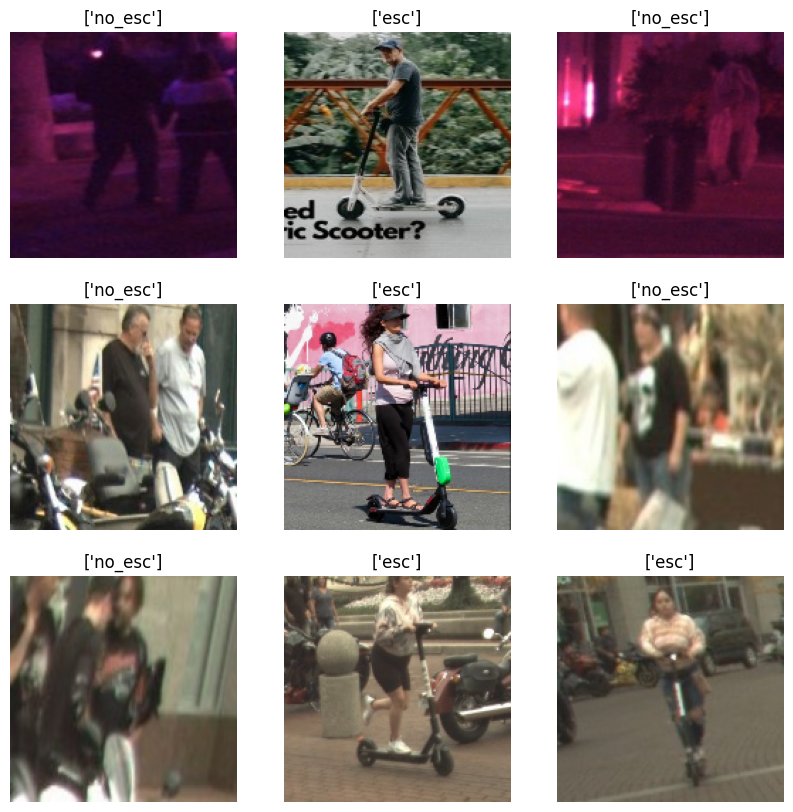

In [ ]:
training = DataLoader(training_dataset, batch_size=32, shuffle=True, collate_fn=None, **kwargs)
tr_images_batch, tr_labels_batch = next(iter(training))

val = DataLoader(val_dataset, batch_size=32, shuffle=True, **kwargs)
test = DataLoader(test_dataset, batch_size=32, shuffle=True, **kwargs)

plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(np.transpose(tr_images_batch[i], (1,2,0)))
  plt.title([str(x) for x in classes if classes[x] == tr_labels_batch[i]])
  plt.axis("off")

In [ ]:
tr_images_batch.shape

torch.Size([32, 3, 160, 160])

# Add Fully-connected Layer for Fine-tuning

Now we add an nn.Linear layer to each model, to be trained on our dataset as a fine-tuning step

In [ ]:
# Duplicate our previous model, removing the classification layer to perform feature extraction
mobilev2_feat_extract = torch.nn.Sequential(*list(mobilev2.children())[:-1])

In [ ]:
# feature_batch = mobilev2_feat_extract(tr_images_batch)
# print(feature_batch.shape)

global_average_layer = torch.nn.AdaptiveAvgPool2d((1,1))
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [ ]:
prediction_layer = torch.nn.Linear(1280, 1)
act = torch.nn.Sigmoid()

# Flatten feature batch
flattened = torch.flatten(feature_batch_average, 1)

pred_batch = prediction_layer(flattened)
pred_batch = act(pred_batch)
print(pred_batch.shape)

NameError: ignored

In [ ]:
# Prepare model for fine-tuning
for param in mobilev2.parameters():
  param.requires_grad = False
mobilev2.classifier[-1] = torch.nn.Linear(1280,2)
mobilev2.features.append(global_average_layer)
print(mobilev2)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# Inspiration from Assignment 2 Implementation
def train_model(model, optimizer, epochs=1):
  model.to(device)
  for e in range(epochs):
    for t, (x, y) in enumerate(training):
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)

      scores = model(x)
      loss = F.cross_entropy(scores, y)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      if t % 100 == 0:
        print('Iteration %d, loss = %.4f' % (t, loss.item()))
        num_correct = 0
        num_samples = 0
        with torch.no_grad():
          for x, y in val:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
          acc = float(num_correct) / num_samples
          print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        print()

In [ ]:
optimizer = optim.Adam(mobilev2.parameters(), lr = 0.0001, weight_decay=1e-5)
train_model(mobilev2, optimizer, 10)

In [ ]:
torch.save(mobilev2.state_dict(), 'mobilev2_prefinetune.pth')

In [ ]:
# Set end layers up for training as in paper
for param in mobilev2.features[16:].parameters():
  param.requires_grad=True

In [ ]:
optimizer = optim.Adam(mobilev2.parameters(), lr = 0.0001, weight_decay=1e-5)
train_model(mobilev2, optimizer, 15)

In [ ]:
# Prepare model for fine-tuning

for param in mobilev3.features.parameters():
  param.requires_grad = False
mobilev3.classifier[-1] = torch.nn.Linear(1280,2)
print(mobilev3)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [ ]:
optimizer = optim.Adam(mobilev3.parameters(), lr = 0.0001, weight_decay=1e-5)
train_model(mobilev3, optimizer, 10)

In [ ]:
torch.save(mobilev3.state_dict(), 'mobilev3_prefinetune.pth')

In [ ]:
# Set end layers up for training as in paper
for param in mobilev3.features[16:].parameters():
  param.requires_grad=True

In [ ]:
optimizer = optim.Adam(mobilev3.parameters(), lr = 0.0001, weight_decay=1e-5)
train_model(mobilev3, optimizer, 15)

In [ ]:
# torch.save(mobilev2.state_dict(), 'mobilev2_finetuned.pth')
torch.save(mobilev3.state_dict(), 'mobilev3_finetuned.pth')

# Evaluation

In [ ]:
import warnings
import torch
import numpy as np
warnings.filterwarnings("ignore")

In [ ]:
mobilev2.classifier[-1] = torch.nn.Linear(1280,2)
mobilev2.features.append(global_average_layer)
mobilev2.load_state_dict(torch.load('modelWeights/mobilev2_finetuned.pth'))

<All keys matched successfully>

In [ ]:
mobilev3.classifier[-1] = torch.nn.Linear(1280,2)
mobilev3.load_state_dict(torch.load('modelWeights/mobilev3_finetuned.pth'))

<All keys matched successfully>

In [ ]:
transform = tf.Compose([
    tf.ToTensor(),
    tf.Resize((160,160))
])

TEST_DIR = 'data/testing'#using testing folder data and dividing into test, train and val
test_dataset = tv.datasets.ImageFolder(root=TEST_DIR, transform=transform)
test = DataLoader(test_dataset, batch_size=32, shuffle=True, **kwargs)

In [ ]:
from sklearn import metrics

def test_model(model, test):
  model.eval()
  test_loss = 0.0
  tp,fp,tn,fn = 0,0,0,0

  actuals = []
  predictions = []

  for data,label in test:
      # data, label = data.cuda(), label.cuda()
      output = model(data)
      for o,l in zip(torch.argmax(output,axis = 1),label):

          if o == l and o.item() == 0:
              tn += 1
          elif o == l and o.item() == 1:
              tp += 1
          elif o != l and o.item() == 0:
              fn += 1
          elif o != l and o.item() == 1:
              fp += 1
          predictions.append(o.item())
          actuals.append(l.item())

      loss = F.cross_entropy(output, label)
      test_loss += loss.item() * data.size(0)

  print(f'Testing Loss:{test_loss/len(test)}')
  print(f'Testing Accuracy: {(tn+tp)/(tn+tp+fp+fn)}')

  matrix = metrics.confusion_matrix(actuals, predictions)
  disp = metrics.ConfusionMatrixDisplay(matrix, display_labels = [False, True])

  disp.plot()
  plt.show()

  tpr = [0,tp/(tp+fn),1]
  fpr = [0,fp/(fp+tn),1]

  plt.plot(fpr, tpr, marker='o')
  plt.title('ROC Curve')
  plt.xlabel('False Positive Rate (FPR)')
  plt.ylabel('True Positive Rate (TPR)')
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.show()


Testing Loss:13.118386007654362
Testing Accuracy: 0.8144288577154308


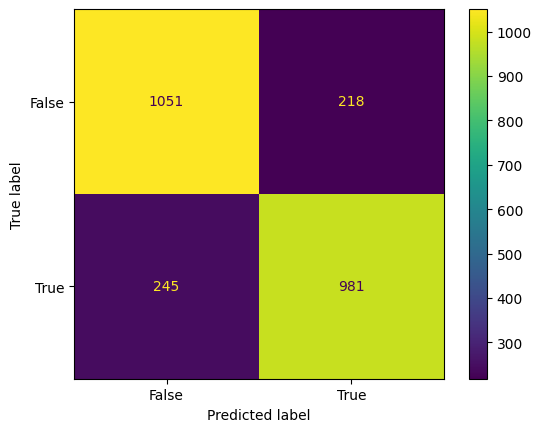

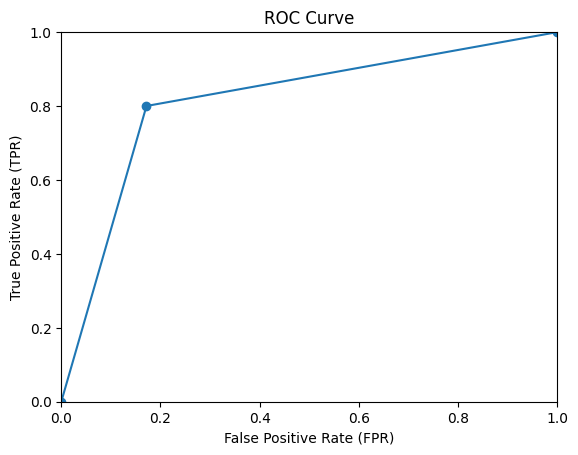

In [ ]:
# Create new, untrained skeleton and apply weights
mobilev2 = tv.models.mobilenet_v2(pretrained=False)
mobilev2.classifier[-1] = torch.nn.Linear(1280,2)
mobilev2.features.append(torch.nn.AdaptiveAvgPool2d((1,1)))
mobilev2.load_state_dict(torch.load('modelWeights/mobilev2_prefinetune.pth'))
mobilev2.eval()

test_model(mobilev2, test)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialia

Testing Loss:18.50079056634926
Testing Accuracy: 0.8961923847695391


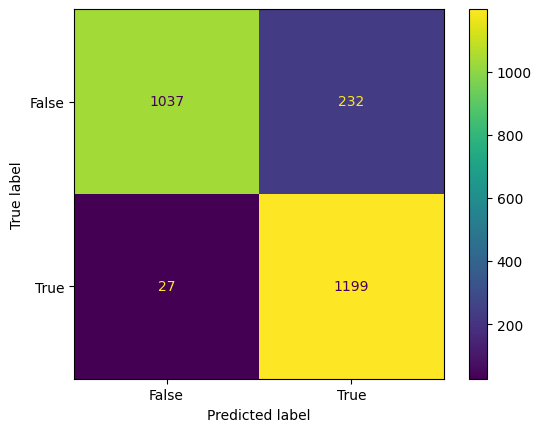

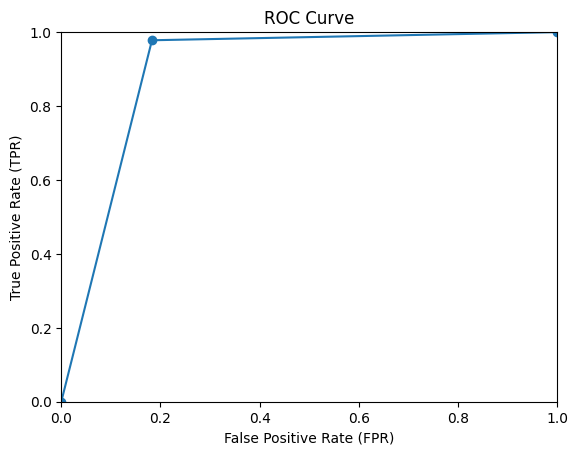

In [ ]:
# Create new, untrained skeleton and apply weights
mobilev2 = tv.models.mobilenet_v2(pretrained=False)
mobilev2.classifier[-1] = torch.nn.Linear(1280,2)
mobilev2.features.append(torch.nn.AdaptiveAvgPool2d((1,1)))
mobilev2.load_state_dict(torch.load('modelWeights/mobilev2_finetuned.pth'))
mobilev2.eval()

test_model(mobilev2, test)

Testing Loss:13.461456914742788
Testing Accuracy: 0.8589178356713427


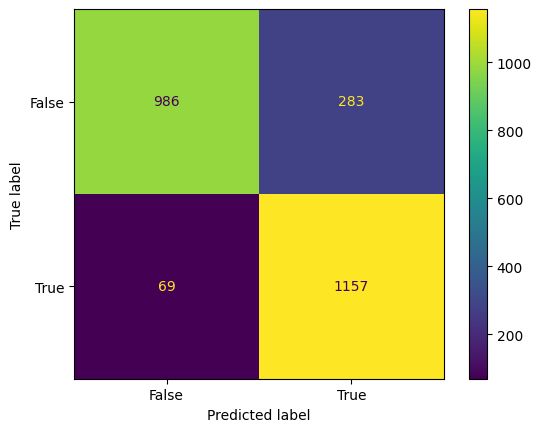

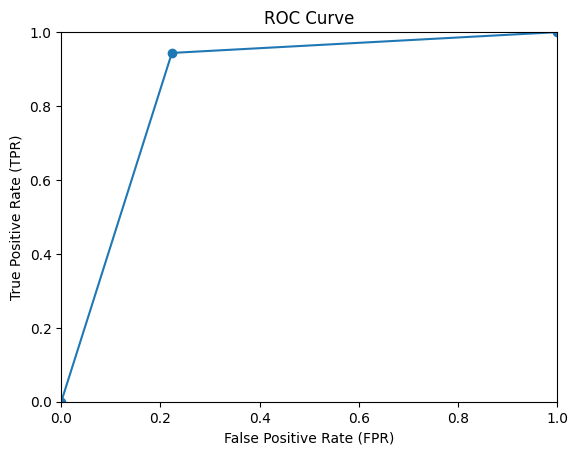

In [ ]:
# Create new, untrained skeleton and apply weights
mobilev3 = tv.models.mobilenet_v3_large(pretrained=False)
mobilev3.classifier[-1] = torch.nn.Linear(1280,2)
mobilev3.load_state_dict(torch.load('modelWeights/mobilev3_prefinetune.pth',map_location=torch.device('cpu')))
mobilev3.eval()

test_model(mobilev3, test)

Testing Loss:20.292622957474148
Testing Accuracy: 0.8661322645290581


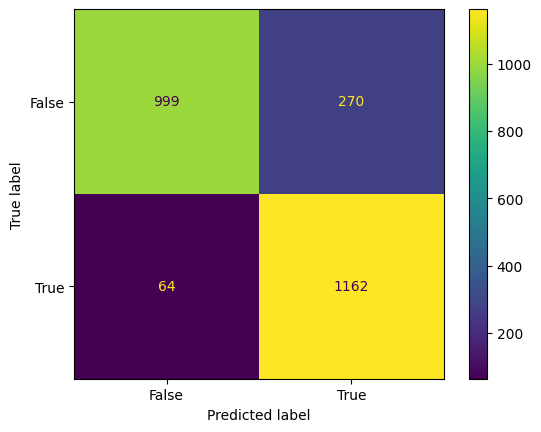

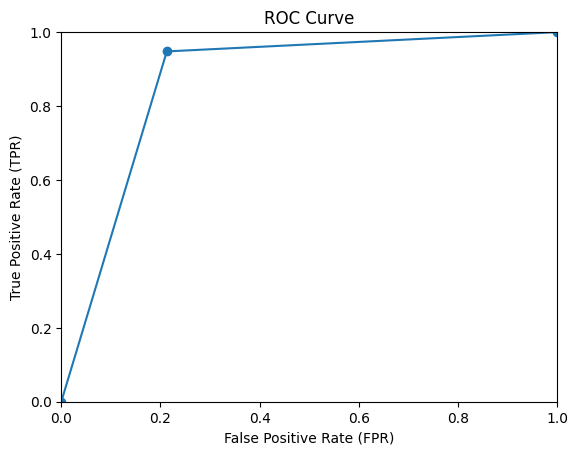

In [ ]:
# Create new, untrained skeleton and apply weights
mobilev3 = tv.models.mobilenet_v3_large(pretrained=False)
mobilev3.classifier[-1] = torch.nn.Linear(1280,2)
mobilev3.load_state_dict(torch.load('modelWeights/mobilev3_finetuned.pth',map_location=torch.device('cpu')))
mobilev3.eval()

test_model(mobilev3, test)